# 泰坦尼克号数据集探索分析

### 项目说明
通过此项目熟悉数据分析基本流程以及Pandas，Numpy，Matplotlib的用法。
### 探索的问题
1. 社会经济地位更高的乘客生还率更高吗？
2. 女性的生还率比男性高吗？
3. 年龄小的乘客生还率更高吗？
4. 乘客生还率与登船的港口有密切联系吗？
5. 有家属在船上的乘客生还率更低吗？   
6. 女性乘客的生还率与其所处的社会经济地位有密切联系吗？

### 数据说明：
* 数据来源及说明见[Kaggle](https://www.kaggle.com/c/titanic/data)。

### 数据清洗
#### 1. 查看需要分析的数据是否有缺失值，异常值等。

In [79]:
# encoding: utf-8

# 加载所需的包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

# 使图形能够正常显示中文标签
plt.rcParams['font.sans-serif']=['Microsoft YaHei']

# 加载数据
titanic_data = pd.read_csv('titanic-data.csv')

# 预览部分数据集
titanic_data.head()

Populating the interactive namespace from numpy and matplotlib


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [80]:
# 统计缺失值
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### 该数据集里 Age 中有 177 个缺失值，Cabin 中有 687 个缺失值，Embarked 中有 2 个缺失值。
注:本次分析中不涉及到 Cabin ，故 Cabin 中的缺失值不需要处理

#### 2. 处理缺失值,调整数据类型
在处理 Age 中的缺失值之前，先看一看年龄的分布情况

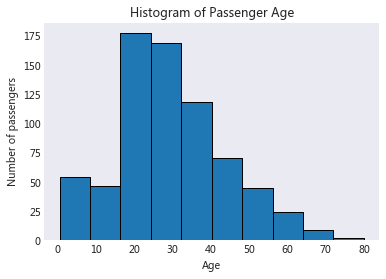

In [81]:
# 绘制年龄分布直方图
titanic_data['Age'].hist(edgecolor='black', grid = False)
plt.xlabel("Age")
plt.ylabel("Number of passengers")
plt.title("Histogram of Passenger Age")

#### 由于 Age 中的缺失值有 177 个，乘客总数为 891 ，删除年龄中的缺失值不太合适,
应该用乘客年龄的中位数或平均值填充缺失值。         
由于年龄分布为正偏态分布，故用年龄的中位数填充缺失值比较合适。

In [82]:
# 用年龄的中位数填充缺失值
titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace = True)

# 检查填充效果
titanic_data['Age'].isnull().sum()

0

#### 由于年龄跨度比较大，为了便于分析，按年龄划分为 ‘儿童’，‘成年’，‘老年’

In [83]:
# 自定义函数把年龄划分为三个年龄段
def convert_age(age):
    '''年龄小于14岁划分到儿童组
       年龄在14到50之间划分到成年组
       年龄大于50岁划分到老年组'''
    if age <= 16:
        return '儿童'
    elif age <= 50:
        return '成年'
    elif age > 50:
        return '老年'
titanic_data['Age'] = titanic_data['Age'].apply(convert_age)
titanic_data.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  成年      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  成年      1   
2                             Heikkinen, Miss. Laina  female  成年      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  成年      1   
4                           Allen, Mr. William Henry    male  成年      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

#### 在处理 Embarked 中的缺失值之前，先看一看其分布情况

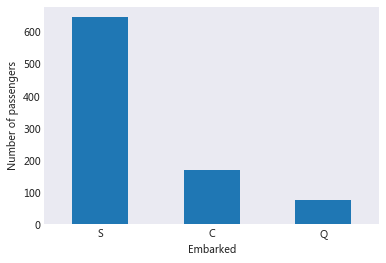

In [84]:
# 绘制 Embarked 分布柱状图
titanic_data['Embarked'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.xlabel("Embarked")
plt.ylabel("Number of passengers")

#### 用众数 S 填充 Embarked 中的缺失值比较合适

In [85]:
# 用众数 S  填充 Embarked 中的缺失值
titanic_data['Embarked'].fillna('S', inplace = True)

# 检查填充效果
titanic_data['Embarked'].isnull().sum()

0

#### 为了便于分析把 SibSp 和 Parch 合并到 Family 列

In [86]:
# 新建 Family 列 
titanic_data['Family'] = titanic_data['SibSp'] + titanic_data['Parch']

def convert_Family(data):
    '''SibSp 和 Parch 值都为 0 时，Family对应的值为无家属
       否则Family对应的值为有家属'''
    if data == 0:
        return '无家属'
    else:
        return '有家属'
titanic_data['Family'] = titanic_data['Family'].apply(convert_Family)
titanic_data.head(3)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  成年      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  成年      1   
2                             Heikkinen, Miss. Laina  female  成年      0   

   Parch            Ticket     Fare Cabin Embarked Family  
0      0         A/5 21171   7.2500   NaN        S    有家属  
1      0          PC 17599  71.2833   C85        C    有家属  
2      0  STON/O2. 3101282   7.9250   NaN        S    无家属

### 数据探索     
#### 问题1:社会经济地位更高的乘客生还率更高吗？

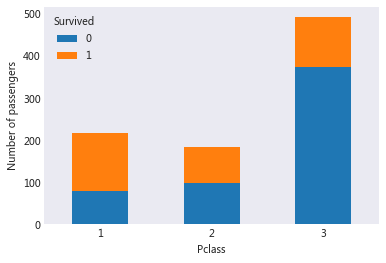

In [87]:
# 按 Pclass 对数据进行分组
group_by_Pclass = titanic_data.groupby('Pclass').Survived.value_counts().unstack()

group_by_Pclass.plot(kind = 'bar', stacked = True)
plt.xticks(rotation = 0)
plt.ylabel("Number of passengers")

In [88]:
print group_by_Pclass

# 自定义用来统计 Pclass 生还率的函数
def survived_rate_by_Pclass(group_by_Pclass, Pclass_num):
    return '%0.2f%%'%(100.0 * group_by_Pclass.loc[Pclass_num, 1] / group_by_Pclass.loc[Pclass_num].sum())

print ''
print "Pclass 1 的生还率为:",survived_rate_by_Pclass(group_by_Pclass, 1)
print "Pclass 2 的生还率为:",survived_rate_by_Pclass(group_by_Pclass, 2)
print "Pclass 3 的生还率为:",survived_rate_by_Pclass(group_by_Pclass, 3)


Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119

Pclass 1 的生还率为: 62.96%
Pclass 2 的生还率为: 47.28%
Pclass 3 的生还率为: 24.24%


#### 由上图可以看出，社会经济地位越高的乘客生还率越低
#### 问题2:女性的生还率比男性高吗？

In [89]:
# 按性别分组
group_by_Sex = titanic_data.groupby('Sex').Survived.value_counts().unstack()

print group_by_Sex.stack()

# 自定义用来统计男女生还率的函数
def survived_rate_by_Sex(group_by_Sex, Sex):
    return '%0.2f%%'%(100.0 * group_by_Sex.loc[Sex, 1] / group_by_Sex.loc[Sex].sum())

print '' # 和之前的输出内容间隔一行
print "男性的生还率为:",survived_rate_by_Sex(group_by_Sex, 'male')
print "女性的生还率为:",survived_rate_by_Sex(group_by_Sex, 'female')

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
dtype: int64

男性的生还率为: 18.89%
女性的生还率为: 74.20%


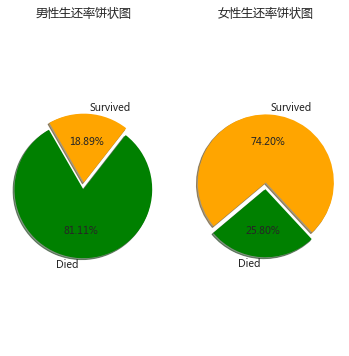

In [90]:
plt.rc('figure', figsize=(6, 6)) # 设置图像大小
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)   # 创建两个 subplot
ax2 = fig.add_subplot(1, 2, 2)

labels = 'Died', 'Survived'      # 设置图中的标签为 Died 和 Survived
explode = (0, 0.1)               # 表示Survived 的那一部分从图中分离
colors = ['green', 'orange']     # 设置饼状图中个部分的颜色

sizes_male = [81.11, 18.89]        # 男性死亡率和生存率
ax1.pie(sizes_male, explode=explode, labels = labels, autopct='%1.2f%%',
        colors = colors, shadow=True, startangle=120)
ax1.axis('equal')
ax1.set_title(u"男性生还率饼状图")

sizes_fmale = [(25.80), (74.20)]       # 女性死亡率和生存率
ax2.pie(sizes_fmale, explode=explode, labels=labels, autopct='%1.2f%%',
        colors=colors, shadow=True, startangle=220)
ax2.axis('equal')
ax2.set_title(u"女性生还率饼状图")

#### 由上述分析可知，女性生还率比男性高。
#### 问题3:年龄小的乘客生还率更高吗？

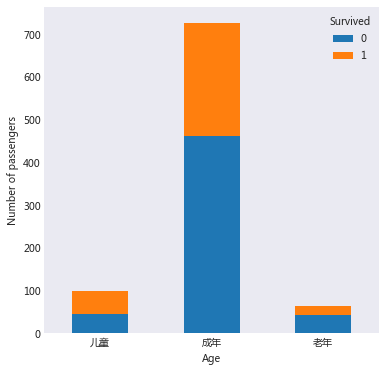

In [91]:
# 按年龄分组
group_by_Age = titanic_data.groupby('Age').Survived.value_counts().unstack()

group_by_Age.plot(kind = 'bar', stacked = True)
plt.xticks(rotation = 0)
plt.ylabel("Number of passengers")

In [92]:
print group_by_Age

# 自定义用来统计不同年龄段生还率的函数
def survived_rate_by_Age(group_by_Age, Age):
    return '%0.2f%%'%(100.0 * group_by_Age.loc[Age, 1] / group_by_Age.loc[Age].sum())

print '' # 和之前的输出内容间隔一行
print "儿童的生还率为:",survived_rate_by_Age(group_by_Age, '儿童')
print "成年的生还率为:",survived_rate_by_Age(group_by_Age, '成年')
print "老年的生还率为:",survived_rate_by_Age(group_by_Age, '老年')

Survived    0    1
Age               
儿童         45   55
成年        462  265
老年         42   22

儿童的生还率为: 55.00%
成年的生还率为: 36.45%
老年的生还率为: 34.38%


#### 由上述分析可知，儿童生还率最高，成年人其次，老年人生还率最低。
#### 问题4:乘客生还率与登船的港口有密切联系吗？

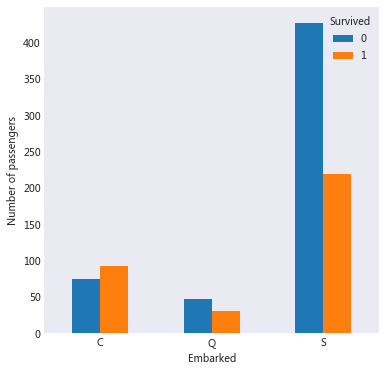

In [93]:
# 按 Embarked 分组
group_by_Embarked = titanic_data.groupby(['Embarked']).Survived.value_counts().unstack()

group_by_Embarked.plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.ylabel("Number of passengers")

In [94]:
print group_by_Embarked

# 自定义用来统计不同年龄段生还率的函数
def survived_rate_by_Embarked(group_by_Embarked, Embarked):
    return '%0.2f%%'%(100.0 * group_by_Embarked.loc[Embarked, 1] / group_by_Embarked.loc[Embarked].sum())

print '' # 和之前的输出内容间隔一行
print "C港口登船的生还率为:",survived_rate_by_Embarked(group_by_Embarked, 'C')
print "Q港口登船的生还率为:",survived_rate_by_Embarked(group_by_Embarked, 'Q')
print "S港口登船的生还率为:",survived_rate_by_Embarked(group_by_Embarked, 'S')

Survived    0    1
Embarked          
C          75   93
Q          47   30
S         427  219

C港口登船的生还率为: 55.36%
Q港口登船的生还率为: 38.96%
S港口登船的生还率为: 33.90%


#### 由上述分析可知，C港口登船的生还率最高，Q其次，S最低。
#### 问题5:有家属在船上的乘客生还率更低吗？

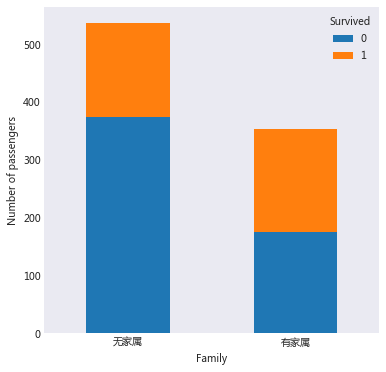

In [95]:
# 按 Family 分组
group_by_Family = titanic_data.groupby('Family').Survived.value_counts().unstack()
group_by_Family.plot(kind = 'bar', stacked = True)
plt.xticks(rotation = 0)
plt.ylabel("Number of passengers")

In [96]:
print group_by_Family

# 自定义用来统计不同年龄段生还率的函数
def survived_rate_by_Family(group_by_Family, Family):
    return '%0.2f%%'%(100.0 * group_by_Family.loc[Family, 1] / group_by_Family.loc[Family].sum())

print '' # 和之前的输出内容间隔一行
print "无家属的生还率为:",survived_rate_by_Family(group_by_Family, '无家属')
print "有家属的生还率为:",survived_rate_by_Family(group_by_Family, '有家属')

Survived    0    1
Family            
无家属       374  163
有家属       175  179

无家属的生还率为: 30.35%
有家属的生还率为: 50.56%


#### 由上述分析可知，有家属在船上的乘客比没有家属的生还率高。

#### 问题6:女性乘客的生还率与其所处的社会经济地位有密切联系吗？

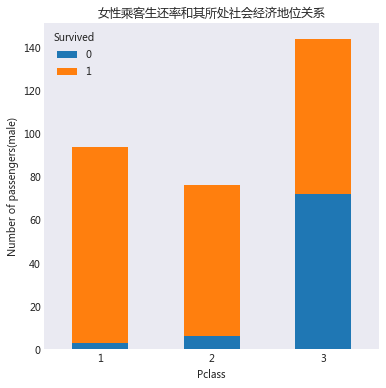

In [97]:
# 按 Sex 和 Pclass 分组
group_by_Pclass_Sex = titanic_data.groupby(['Sex', 'Pclass']).Survived.value_counts().unstack()

group_by_Pclass_Sex.loc['female'].plot(kind = 'bar', stacked = True)
plt.ylabel("Number of passengers(male)")
plt.xticks(rotation = 0)
plt.title(u"女性乘客生还率和其所处社会经济地位关系")

In [99]:
print group_by_Pclass_Sex.loc['female']

# 自定义用来统计不同社会经济地位的女性乘客生还率的函数
def female_survived_rate_by_Pclass(male, Pclass):
    return '%0.2f%%'%(100.0 * male.loc[Pclass, 1] / male.loc[Pclass].sum())

print '' # 和之前的输出内容间隔一行
print "Pclass为1的女性的生还率为:",female_survived_rate_by_Pclass(group_by_Pclass_Sex.loc['female'], 1)
print "Pclass为2的女性的生还率为:",female_survived_rate_by_Pclass(group_by_Pclass_Sex.loc['female'], 2)
print "Pclass为3的女性的生还率为:",female_survived_rate_by_Pclass(group_by_Pclass_Sex.loc['female'], 3)

Survived   0   1
Pclass          
1          3  91
2          6  70
3         72  72

Pclass为1的女性的生还率为: 96.81%
Pclass为2的女性的生还率为: 92.11%
Pclass为3的女性的生还率为: 50.00%


#### 通过上面分析可以看出，对所有乘客而言，女性乘客的生还率为74.2%，      
但是不同社会经济地位的女性乘客之间的生还率有着很大的区别，    
Pclass为1的女性的生还率高达96.81%   
Pclass为3的女性的生还率只有50.00%

### 结论
1. 社会经济地位越高的乘客生还率越低
2. 女性的生还率比男性高
3. 年龄小的乘客生还率更高
4. C港口登船的乘客生还率最高
5. 有家属在船上的乘客生还率更高   
6. 女性乘客所处的社会经济地位越低生还率越高  

#### 以上结论只是暂时性的，原因如下
1. 泰坦尼克号船上实际人数为2224人，本次分析所用数据集中只有891人
2. 本次分析中没有涉及到类似于相关性之类的统计学知识
3. 对于缺失值只是简单的用众数填充
4. 对于乘客的年龄划分为儿童，中年，老年三个级别，也会对分析结果造成影响
5. 把 SibSp 列和 Parch 列合并到 Family列，使得 SibSp 和 Parch 对生还率的影响部分分析的不够细

### 参考资料
1. http://www.jianshu.com/p/ac00d44214d8
2. https://matplotlib.org/2.0.2/examples/pie_and_polar_charts/pie_demo_features.html
3. http://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html
4. http://blog.csdn.net/lanchunhui/article/details/52850631
